In [1]:
PROJECT_PATH = '../..'
DATASET_PATH='/home/swei20/cancerHH/AceCanZ/data/cancer_data/pretrain/RF/n8/stream_b22.txt'
# DATASET_PATH = '/scratch/ceph/dobos/data/pfsspec/train/stellar/grid/bosz_hires_test'

In [103]:
import os
import sys
import numpy as np
import pandas as pd
import copy
from collections import Counter
import warnings
warnings.simplefilter("ignore")
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MultipleLocator

In [3]:
sys.path.insert(0, PROJECT_PATH)

In [4]:
# from cancer.prepro.data.dataset import Dataset
from util.HH import *
from util.prepro import horner_decode
from util.csvec import CSVec

In [5]:
stream=np.loadtxt(DATASET_PATH)

In [6]:
streamLen=stream.shape[0]

In [15]:
topk=2000
base=22
ftr_len=8
dtype='uint64'
EXACT=True

In [16]:
%time HH_pd=get_HH_pd(stream,base,ftr_len, dtype, EXACT, topk, r=4, d=100000,c=None,device=None)

=============exact counting HHs==============
exact counting time:5.14
CPU times: user 5.32 s, sys: 76.6 ms, total: 5.39 s
Wall time: 5.32 s


In [23]:
def profile(fn):
    pr = profile.Profile(fn)
    p.sort_stats(SortKey.CUMULATIVE).print_stats(10)

In [12]:
def get_exact_HH(stream):
    exactHH=np.array(Counter(stream).most_common())
    return exactHH

def get_relative_error(exactHH,cHH,cFreq):
    k=len(cHH)
    errVec, setAcc = np.ones(k), 0
    for ii in range(k):
        eHH_i, eFreq_i = exactHH[ii,0], exactHH[ii,1]
        if eHH_i in cHH:
            c1 = cFreq[cHH == eHH_i]
            errVec[ii] -= c1/eFreq_i
            setAcc+=1
    setAcc=setAcc/k
    err=abs(errVec).sum()
    print(f'top {k}|err {err}|setAcc {setAcc}')
    return errVec, err, acc

In [14]:
exact_HH=get_exact_HH(stream)

In [16]:
exact_HH.shape

(261414, 2)

In [94]:
%time exactHH=get_exact_HH(stream)

CPU times: user 5.52 s, sys: 58 ms, total: 5.58 s
Wall time: 5.5 s


In [84]:
%timeit exactHH=get_exact_HH(stream)

5.25 s ± 215 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [85]:
%prun exactHH=get_exact_HH(stream)

In [91]:
%load_ext line_profiler
%load_ext memory_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [11]:
exactHH=get_exact_HH(stream)

TypeError: get_exact_HH() missing 1 required positional argument: 'topk'

In [92]:
%memit exactHH=get_exact_HH(stream)

peak memory: 2281.76 MiB, increment: 21.73 MiB


In [109]:
exactHH[:2000,1].sum()

10752439.0

In [19]:
stream_tr

NameError: name 'stream_tr' is not defined

In [181]:
def get_np_cs(cHHs,cFreqs, k):
    cFreqs=cFreqs.cpu().numpy()
    cFreqs=np.clip(cFreqs,0,None)
    idx=np.argsort(-1*cFreqs)    
    HHfreq=np.vstack((cHHs.numpy(),cFreqs))
    shh,sfreq=HHfreq[:,idx][:,:k]
    return shh, sfreq
 

In [182]:
exactRank=exactHH[:,1].cumsum()/stream_len

In [514]:
def get_relative_error(exactHH,cHHs,cFreqs, prepro=False, k=None):
    if prepro:
        cHHs, cFreqs = get_np_cs(cHHs,cFreqs, k)
    else:
        k = len(cHHs)
#     perc=np.round(exactHH[:k,1].sum()/exactHH[:,1].sum()*100).astype('int')
    errVec, setAcc, Acc5 = np.ones(k), 0, 0
    for ii in range(k):
        eHH_i, eFreq_i = exactHH[ii,0], exactHH[ii,1]
        if eHH_i in cHHs:
            c1 = cFreqs[cHHs == eHH_i]
            errVec[ii] -= c1/eFreq_i
            setAcc+=1
        if ii == 34:
            Acc5=setAcc/(ii+1)
#         if ii == 
    setAcc=np.round(setAcc/k,2)
    err=abs(errVec).sum()
    print(f'top {k}|err {err.round(2)}|Acc5% {Acc5} | Acc{perc}% {setAcc}')
    return errVec, err, acc

In [573]:
def get_recovery_rate(exactHH,cHHs,cFreqs, prepro=False, k=None):
    if prepro:
        cHHs, cFreqs = get_np_cs(cHHs,cFreqs, k)
    else:
        k = len(cHHs)
    eFreqs=exactHH[:,1]
    total=eFreqs.sum()
    rank=eFreqs.cumsum()
    alpha=eFreqs/total   
#     perc=np.round(exactHH[:k,1].sum()/exactHH[:,1].sum()*100).astype('int')
    errVec, setAcc, Acc5 = np.ones(k), 0, 0
    for ii in range(k):
        eHH_i, eFreq_i = exactHH[ii,0], exactHH[ii,1]
        if eHH_i in cHHs:
            c1 = cFreqs[cHHs == eHH_i]
            errVec[ii]= abs(c1-eFreq_i)/eFreq_i
#     print(f'top {k}|err {err.round(2)}|Acc5% {Acc5} | Acc{perc}% {setAcc}')
    rec01=1-errVec[:np.where(alpha-0.001>=0)[0][-1]+1].cumsum()[-1]
    print(f'top {k}|rec {rec01.round(2)}')

    return errVec,alpha,rec01,rank

In [574]:
k=3150
cHHs, cFreqs = get_np_cs(mHHs,mFreqs, k=k)

In [575]:
errVec,alpha,rec01,erank=get_recovery_rate(exactHH,cHHs,cFreqs,False)

top 3150|rec 0.94


Text(0, 0.5, 'recovery rate: 1-|fi-fcs_i|/fi')

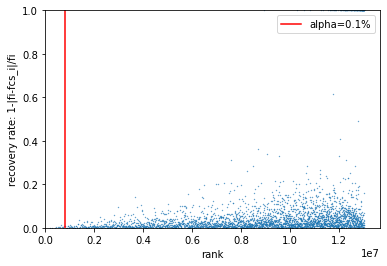

In [587]:
plt.scatter(erank[:k],errVec,s=0.1)
plt.axvline(erank[13], c='r',label='alpha=0.1%')
plt.ylim(0,1)
plt.xlim(0)
plt.legend()
plt.xlabel('rank')
plt.ylabel('recovery rate: 1-|fi-fcs_i|/fi')

In [572]:
errVec.cumsum()

array([8.93114236e-04, 9.89533854e-04, 1.63513397e-03, ...,
       2.54043269e+02, 2.55043269e+02, 2.56043269e+02])

In [ ]:
plt.plot(np.log(alpha[:2000]),errVec)
plt.xlabel('alpha')
plt.ylabel('Relative Error')

In [562]:
from scipy.stats import gaussian_kde

In [568]:
x=alpha[:k]

In [ ]:
y=

Text(0, 0.5, 'recovery rate: 1-|fi-fcs_i|/fi')

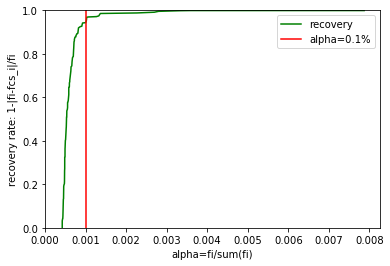

In [547]:
# plt.plot(alpha[:2000],errVec.cumsum(), label='err')
plt.plot(alpha[:2000],1-errVec.cumsum(),c='green', label='recovery')

plt.axvline(0.001,c='r', label='alpha=0.1%')
plt.ylim(0,1)
plt.xlim(0)
plt.legend()
plt.xlabel('alpha=fi/sum(fi)')
plt.ylabel('recovery rate: 1-|fi-fcs_i|/fi')

In [95]:
import torch

In [484]:
import math
import numpy as np
import copy
import torch
LARGEPRIME = 2**61-1
torch.random.manual_seed(42)
class CSVec(object):
    def __init__(self, d, c, r, k, device=None):
        self.r = r # num of rows
        self.c = c # num of columns
        self.d = int(d) # vector dimensionality
        if device is None:
            device = 'cuda' if torch.cuda.is_available() else 'cpu'
        else:
            if (not isinstance(device, torch.device) and
                    not ("cuda" in device or device == "cpu")):
                msg = "Expected a valid device, got {}"
                raise ValueError(msg.format(device))
        self.device = device
        self.table = torch.zeros((r, c), device=self.device)

        torch.random.manual_seed(42)
        rand_state = torch.random.get_rng_state()

        self.hashes = torch.randint(0, LARGEPRIME, (self.r, 6),
                               dtype=torch.int64, device="cpu")
        torch.random.set_rng_state(rand_state)
        self.h1 = self.hashes[:,0:1]
        self.h2 = self.hashes[:,1:2]
        self.h3 = self.hashes[:,2:3]
        self.h4 = self.hashes[:,3:4]
        self.h5 = self.hashes[:,4:5]
        self.h6 = self.hashes[:,5:6]

        self.topk = torch.zeros((k,2), dtype=torch.int64, device=self.device)        
    
#     def accumulateVec(self, vec1, vec2):
#         vec1 = vec1.to(self.device)
#         vec2 = vec2.to(self.device)

#         assert(len(vec.size()) == 1)
#         signs = (((self.h1 * vec + self.h2) * vec + self.h3) * vec + self.h4)
#         signs = ((signs % LARGEPRIME % 2) * 2 - 1).float()
#         signs = signs.to(self.device)

#         # computing bucket hashes (2-wise independence)

#         buckets = ((self.h5 * vec) + self.h6) % LARGEPRIME % self.c
#         buckets = buckets.to(self.device)

#         # the vector is sketched to each row independently
#         for r in range(self.r):
#             bucket = buckets[r,:]
#             sign = signs[r,:]
#             # print('bucket', r, bucket, sign)
#             self.table[r,:] += torch.bincount(input=bucket,
#                                               weights=sign,
#                                               minlength=self.c)
            
    def _findValues(self, vec):
        # computing sign hashes (4 wise independence)
        signs = (((self.h1 * vec + self.h2) * vec + self.h3) * vec + self.h4)
        signs = ((signs % LARGEPRIME % 2) * 2 - 1).float()
        signs = signs.to(self.device)

        # computing bucket hashes (2-wise independence)
        buckets = ((self.h5 * vec) + self.h6) % LARGEPRIME % self.c
        buckets = buckets.to(self.device)  
        # estimating frequency of input coordinates
        d = vec.size()[0]
        vals = torch.zeros(self.r, d, device=self.device)
        for r in range(self.r):
            vals[r] = self.table[r, buckets[r]] * signs[r]
        return vals.median(dim=0)[0]

    def accumulateVec(self, vec):
        assert(len(vec.size()) == 1)
        signs = (((self.h1 * vec + self.h2) * vec + self.h3) * vec + self.h4)
        signs = ((signs % LARGEPRIME % 2) * 2 - 1).float()
        signs = signs.to(self.device)
        # computing bucket hashes (2-wise independence)
        buckets = ((self.h5 * vec) + self.h6) % LARGEPRIME % self.c
        buckets = buckets.to(self.device)
        for r in range(self.r):
            bucket = buckets[r,:]
            sign = signs[r,:]
            self.table[r,:] += torch.bincount(input=bucket,
                                                weights=sign,
                                                minlength=self.c)
    def query(self, vec):
        signs = (((self.h1 * vec + self.h2) * vec + self.h3) * vec + self.h4)
        signs = ((signs % LARGEPRIME % 2) * 2 - 1).float()
        signs = signs.to(self.device)
        # computing bucket hashes (2-wise independence)
        buckets = ((self.h5 * vec) + self.h6) % LARGEPRIME % self.c
        buckets = buckets.to(self.device)
        vals = torch.zeros(self.r, vec.size()[0],dtype=torch.int64, device=self.device)#
        for r in range(self.r):
            bucket = buckets[r,:]
            sign = signs[r,:]           
            vals[r] = self.table[r, bucket] * sign
        return vals.median(dim=0)[0]



In [21]:
stream_tr=torch.tensor(stream, dtype=torch.int64)
stream0_tr=torch.tensor(stream[:10000], dtype=torch.int64)


In [28]:
stream_tr_aug=torch.cat([stream_tr]*100)

In [29]:
stream_tr_aug.shape[0]//1e9

2.0

In [32]:
d=100000
r=10
k=1000
c=20000
device=None
# csv1=CSVec(d, 20000, 10, topk, device=device)


In [33]:
%time mHHs, mfreqs =get_CS_HH(stream_tr, d,c,r,k,device)

CPU times: user 55.9 s, sys: 4.33 s, total: 1min
Wall time: 8.91 s


In [35]:
mHHs.shape

torch.Size([261414])

In [47]:
sizeList=np.array([1e4,5*1e4,1e5,5*1e5,1e6,5*1e6,1e7,1e8,1e9]).astype('int')

In [ ]:
stream

In [ ]:
sizeListLong=np.array([1e8,1e9,1e10]).astype('int')

In [ ]:
%time aHHs, afreqs =get_CS_HH_1b(stream_tr_aug[:int(1e9)], d,c,r,k,device,mHHs)

In [46]:
%time aHHs, afreqs =get_CS_HH_1b(stream_tr_aug[:int(1e9)], d,c,r,k,device,mHHs)

CPU times: user 33min 2s, sys: 2min 20s, total: 35min 22s
Wall time: 1min 29s


In [48]:
def get_scale_time(stream_tr, d,c,r,k,device,mHHs,sizeList):
    t_d100k=[]
    for size in sizeList:
        t=%timeit -o get_CS_HH_1b(stream_tr[:size], d,c,r,k,device,mHHs)
        t_d100k.append(t.average)
    t_d100k=np.array(t_d100k)*1000
    return t_d100k

In [51]:
tSingle=get_scale_time(stream_tr_aug, d,c,r,k,device,mHHs,sizeList)

42.7 ms ± 2.75 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
42.9 ms ± 2.16 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
41.9 ms ± 3.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
80.3 ms ± 4.39 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
115 ms ± 3.69 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
427 ms ± 26.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
839 ms ± 31.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
8.28 s ± 152 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1min 21s ± 791 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [52]:
def get_query_scale(stream_tr,sizeList):
    ts=[]
    for size in sizeList:
        t=%timeit -o stream_tr[:size].unique() 
        ts.append(t.average)
    ts=np.array(ts)*1000
    return ts

In [64]:
tHHs=get_query_scale(stream_tr_aug,sizeList)

354 µs ± 28.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.11 ms ± 4.03 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.88 ms ± 184 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
7.23 ms ± 83.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
13.1 ms ± 179 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
101 ms ± 802 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
196 ms ± 418 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.81 s ± 168 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
20.9 s ± 2.14 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [62]:
tSingle

array([4.26530756e+01, 4.28511545e+01, 4.18887338e+01, 8.03237588e+01,
       1.15041513e+02, 4.26654427e+02, 8.39383298e+02, 8.28003733e+03,
       8.15756130e+04])

In [ ]:
stream_tr.unique()

In [69]:
def plot_scale(sizeList,tSingle,xlbl,ylbl,lbl,c='red'):
    
    plt.scatter(sizeList,tSingle, c=c, label=lbl)
    plt.plot(sizeList,tSingle, c='grey', alpha=0.5)
    
#     plt.scatter(sizeList,teSingle, c='b', label='Exact')
#     plt.plot(sizeList,teSingle, c='grey', alpha=0.5)
    plt.legend()
    plt.xlabel(xlbl)
    plt.ylabel(ylbl)

In [71]:
tHHs[-1]

20885.4148962668

In [74]:
tTotal=tHHs+tSingle

In [79]:
tTotal[-1]/1000-60)

42.461027942597866

In [104]:
sizeList

array([     10000,      50000,     100000,     500000,    1000000,
          5000000,   10000000,  100000000, 1000000000])

In [109]:
tHHs+tSingle

array([4.30071489e+01, 4.39656168e+01, 4.37693729e+01, 8.75586101e+01,
       1.28124796e+02, 5.28034854e+02, 1.03501624e+03, 1.00950331e+04,
       1.02461028e+05])

In [108]:
np.savetxt('CStime.txt', tHHs+tSingle)

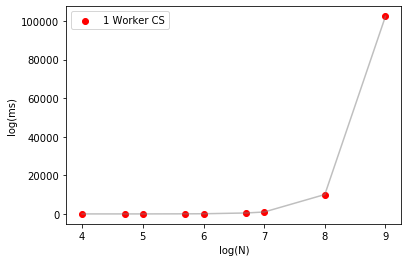

In [81]:
plot_scale(np.log10(sizeList),tHHs+tSingle,'log(N)','log(ms)','1 Worker CS')

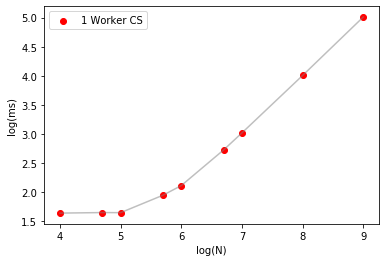

In [72]:
plot_scale(np.log10(sizeList),np.log10(tHHs+tSingle),'log(N)','log(ms)')

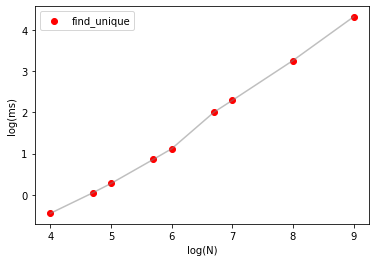

In [70]:
plot_scale(np.log10(sizeList),np.log10(tHHs+),'log(N)','log(ms)','find_unique')

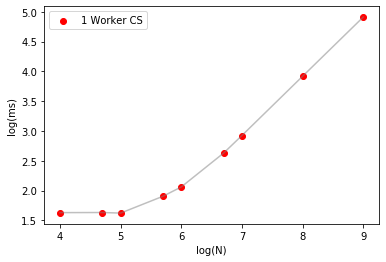

In [61]:
plot_scale(np.log10(sizeList),np.log10(tSingle),None,'log(N)','log(ms)')

In [241]:
import timeit
from concurrent.futures import ThreadPoolExecutor, as_completed

In [85]:
def get_CS_table(stream_tr, d,c,r,k,device):
    csv=CSVec( d, c, r, k, device=device)
    for ii in range(stream_tr.shape[0]//d+1):
        substream=stream_tr[ii*d:(ii+1)*d]
        csv.accumulateVec(substream)
    table=csv.table
    del csv
    return table

def get_CS_parallel_args(stream_tr,d,c,r,k,device,nThread):
    patch=int(stream_tr.shape[0]//nThread)
    stream_loader = lambda x: get_CS_table(stream_tr[x*patch:(x+1)*patch],d,c,r,k,device)
    csv0= CSVec( d, c, r, k, device=device) 
    return stream_loader, csv0

def get_CS_para(stream_tr,d,c,r,k,device,nThread,HHs):
    stream_loader, csv0=get_CS_parallel_args(stream_tr,d,c,r,k,device,nThread)
    for i in range(nThread):
        csv0.table += stream_loader(i)
    return csv0
    # def get_CS_parallel_args(stream_tr,d,c,r,k,device):
#     nThread=int(stream_tr.shape[0]//d)
#     stream_loader = lambda x: get_CS_table(stream_tr[x*d:(x+1)*d],d,c,r,k,device)
#     csv0= CSVec( d, c, r, k, device=device) 
#     return nThread, stream_loader, csv0

In [91]:
threadList=[1,2,4,8,16,32]

In [94]:
def get_parallel_scale(stream_tr,threadList):
    ts=[]
    for thread in threadList:
        t=%timeit -o get_CS_para(stream_tr,d,c,r,k,device,thread,mHHs)
        ts.append(t.average)
    ts=np.array(ts)*1000
    return ts

In [97]:
tParallel = get_parallel_scale(stream_tr[:int(1e6)],threadList)

94.1 ms ± 3.83 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
91.2 ms ± 5.15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
101 ms ± 3.71 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
121 ms ± 3.03 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
104 ms ± 4.22 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
173 ms ± 9.54 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [99]:
tt=np.divide(tParallel, threadList)

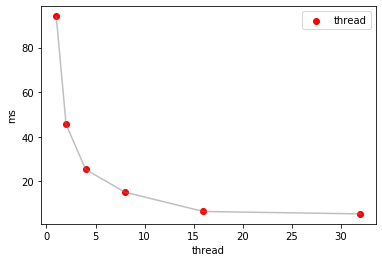

In [101]:
plot_scale(threadList, tt, 'thread','ms','thread')

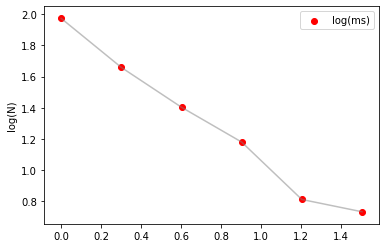

In [102]:
plot_scale(np.log10(threadList),np.log10(tt),None,'log(N)','log(ms)')

In [88]:
%time get_CS_para(stream_tr[:1000],d,c,r,k,device,nThread,mHHs)

CPU times: user 10.3 ms, sys: 1.03 ms, total: 11.4 ms
Wall time: 9.37 ms


In [ ]:
#     patch=int(stream_tr.shape[0]//nThread)
#     stream_loader = lambda x: get_CS_table(stream_tr[x*patch:(x+1)*patch],d,c,r,k,device)
#     csv0= CSVec( d, c, r, k, device=device) 


In [30]:
def get_CS_HH_1b(stream_tr, d,c,r,k,device,HHs):
#     HHs=stream_tr.unique()
    csv=CSVec( d, c, r, k, device=device)    
    for ii in range(stream_tr.shape[0]//d+1):
        substream=stream_tr[ii*d:(ii+1)*d]
        csv.accumulateVec(substream)
    freqs=csv.query(HHs)
    return HHs, freqs

In [17]:
def get_CS_HH(stream_tr, d,c,r,k,device):
    HHs=stream_tr.unique()
    csv=CSVec( d, c, r, k, device=device)    
    for ii in range(stream_tr.shape[0]//d+1):
        substream=stream_tr[ii*d:(ii+1)*d]
        csv.accumulateVec(substream)
    freqs=csv.query(HHs)
    return HHs, freqs
        

In [610]:
# def get_CS_HH_parallel(stream_tr,d,c,r,k,device,nThread):
#     HHs=stream_tr.unique()
#     patch=int(stream_tr.shape[0]//nThread)
#     stream_loader = lambda x: get_CS_table(stream_tr[x*patch:(x+1)*patch],d,c,r,k,device)
#     csv0= CSVec( d, c, r, k, device=device) 
#     with ThreadPoolExecutor() as executor: 
#         futures = []
#         for idx in range(nThread+1):
#             futures.append(executor.submit(stream_loader, idx))
#             # print(f" No.{idx} image is loaded")
#         for future in as_completed(futures):
#             table = future.result()
#             csv0.table += table
#     freqs=csv0.query(HHs)
#     return HHs, freqs 

# def get_CS_table(stream_tr,d,c,r,k,device):
#     csv=CSVec( d, c, r, k, device=device) 
#     for ii in range(stream_tr.shape[0]//d+1):
#         substream=stream_tr[ii*d:(ii+1)*d]
#         csv.accumulateVec(stream_tr)
#         table=csv.table
#         del csv
#         return table

In [659]:
def get_CS_parallel_args(stream_tr,d,c,r,k,device):
    nThread=int(stream_tr.shape[0]//d)
    stream_loader = lambda x: get_CS_table(stream_tr[x*d:(x+1)*d],d,c,r,k,device)
    csv0= CSVec( d, c, r, k, device=device) 
    return nThread, stream_loader, csv0

# def get_CS_table(stream_tr,d,c,r,k,device):
#     csv=CSVec( d, c, r, k, device=device) 
#     csv.accumulateVec(stream_tr)
#     table=csv.table
#     del csv
#     return table
def get_CS_table(args):
    stream_tr, d,c,r,k,device=[*args]
    csv=CSVec( d, c, r, k, device=device) 
    csv.accumulateVec(stream_tr)
    table=csv.table
    del csv
    return table
def get_stream_loader(d,c,r,k,device):
    return lambda x: get_CS_table(x, d,c,r,k,device)

In [ ]:
%time mHHs, mfreqs =get_CS_HH(stream_tr, d,c,r,k,device)

In [662]:
from torch.multiprocessing import Process, Array, Pool,set_start_method

In [649]:
stream_loader = get_stream_loader(d,c,r,k,device)

In [657]:
[(stream0_tr[i*d:(i+1)*d],d,c,r,k,device) for i in range(2)]

[(tensor([36584152397, 36584152397, 36584152397, 36584152397, 36584152397,
          36584152397, 36584152397, 36584152397, 36584152397, 36584151913,
          36584151891, 36584151891, 36584151869, 36583925645, 36583915481,
          36584159923, 36578986576, 36578986576, 36584140714, 36584151384,
          36584151406, 36584151891, 36584151891, 36584152397, 36584152397,
          36584152397, 36584152375, 36584152375, 36584151891, 36584151891,
          36584151869, 36584151847, 36584151319, 36584151824, 36584151869,
          36584151869, 36584151891, 36584152375, 36584152375, 36584152375,
          36584152397, 36584152375, 36584151869, 36584151869, 36584151847,
          36584151846, 36584141265, 36584141265, 36584141243, 36584151891,
          36584151869, 36584151362, 36687218792, 36687218792, 36687208649,
          36687209133, 36687209133, 36687209638, 36687220286, 36692373918,
          36692373918, 36692373896, 36692140124, 36692140123, 36692140101,
          36692151233, 36

In [663]:
set_start_method('spawn', force=True)
with Pool(4) as pool:
    print(pool.map(get_CS_table, [(stream0_tr[i*d:(i+1)*d],d,c,r,k,device) for i in range(2)]))

KeyboardInterrupt: 

In [623]:
d=1000
c=100
r=2
k=100

In [624]:
nThread, stream_loader, csv0=get_CS_parallel_args(stream0_tr,d,c,r,k,device)

In [634]:
ps=[]
for i in range(4):
    p = mp.Process(target=f, args=(i,))
    ps.append(p)
    p.start()

In [637]:
for p in ps: p.join()

In [641]:
p.results()

AttributeError: 'Process' object has no attribute 'results'

In [629]:
# model.share_memory() # Required for 'fork' method to work
processes = []
# for i in range(nThread): # No. of processes
arr=Array('i',range(nThread))    
p = Process(target=stream_loader, args=(arr))
p.start()
# processes.append(p)
# for p in processes: p.join()
p.join()

Process Process-9:
Traceback (most recent call last):
  File "/home/swei20/.conda/envs/ptorch/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/swei20/.conda/envs/ptorch/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
TypeError: <lambda>() takes 1 positional argument but 10 were given


In [ ]:
get_CS_HH(stream_tr[:size], 100000, 20000, 10, 1000, device=None)    

In [480]:
d,c,r,k,device = 100000,20000,10,1000,None
nThread=4

In [482]:
%time exact_HH =get_exact_HH(stream)

CPU times: user 14.3 s, sys: 6.86 s, total: 21.2 s
Wall time: 5.91 s


In [594]:
%time mHHs, mfreqs =get_CS_HH(stream_tr, d,c,r,k,device)

KeyboardInterrupt: 

In [593]:
# %time mHHs, mfreqs =get_CS_HH(stream_tr, d,c,r,k,device, 4)

In [488]:
mHHs, mfreqs =get_CS_HH(stream_tr, d,c,r,k,device)

In [478]:
stream_tr

tensor([36584152397, 36584152397, 36584152397,  ..., 36584105780,
        36578962312, 34084614588])

In [473]:
stream_tr

tensor([36584152397, 36584152397, 36584152397,  ..., 36584105780,
        36578962312, 34084614588])

In [486]:
# %time mHHs, mfreqs =get_CS_HH(stream_tr, d,c,r,k,device, nThread)

In [424]:
dList=[streamLen//i for i in [1,2,4,8,16,32,64,128,256]]

In [416]:
dList

[26034006, 13017003, 6508501, 3254250, 1627125, 813562, 406781, 203390, 101695]

In [ ]:
t_d100k=[]

for d in dList[-1:]:
    t=%timeit -o get_CS_HH(stream_tr, d,c,r,k,device, parallel=False)
    t_d100k.append(t.average)
t_d100k=np.array(t_d100k)*1000

In [420]:
t_d100k=[]

for d in dList[-1:]:
    t=%timeit -o get_CS_HH(stream_tr, d,c,r,k,device, parallel=False)
    t_d100k.append(t.average)
t_d100k=np.array(t_d100k)*1000

2.33 s ± 90.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [422]:
dList=np.array([1e4,5e4,1e5,2e5,4e5,8e5]).astype('int')

In [423]:
tp_d100k=[]

for d in dList:
    t=%timeit -o get_CS_HH(stream_tr, d,c,r,k,device, parallel=True)
    tp_d100k.append(t.average)
tp_d100k=np.array(tp_d100k)*1000

6.5 s ± 57.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.78 s ± 72.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.38 s ± 59 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.69 s ± 181 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.38 s ± 233 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
4.99 s ± 147 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%timeit -o get_CS_HH(stream0_tr, d,c,r,k,device, parallel=False)

In [419]:
d, c, r, k

(101695, 20000, 10, 1000)

In [365]:
cHHs,cfreqs=get_CS_HH(stream_tr,d,c,r,3150,device)
errVec,err,setAcc = get_relative_error(exactHH,cHHs, cfreqs, True, k=3150)

tensor([42,  0,  0,  ...,  0,  0,  0], dtype=torch.uint8)
tensor([[2297359619001564597, 1396682528897996053, 1973689801170867276,
         1819927849474927640,  572192888165898362,  571748048327668951],
        [1071453510346823114, 2143071682933157242, 1865242737500154731,
         1532418594269339783,  379716980844854580, 1750777661071092062],
        [1520798217888136611, 1611122243678701954, 1048235628103308220,
         1077373049702139041, 1000592739665268027,  456675647751657728],
        [1050450229337746267,  760543396461257180, 2063321781277379074,
          267364570529679360,  777431531920034493, 2146497176616232720],
        [1495477363401685952,  648881935158774723, 1377488174878099308,
          262579006026876151, 1704747971477620220,  856858769658023396],
        [1983852346201383562,  839771884757445449, 1199990111390225681,
         1362947483897176671, 1671865959972055060, 1077240956986238975],
        [1007446255075745115, 1801732545371167617, 1092656530294298720,


In [392]:
errVec,err,setAcc = get_relative_error(exactHH,mHHs, mfreqs, True, k=3150)

top 3150|err 256.04|Acc5% 1.0 | Acc50% 0.96


In [487]:
errVec,err,setAcc = get_relative_error(exactHH,mHHs, mfreqs, True, k=3150)

top 3150|err 256.04|Acc5% 1.0 | Acc50% 0.96


In [675]:
tt=[stream_tr]*100

In [676]:
stream_tr_aug=torch.cat(tt)

In [677]:
stream_tr_aug.shape

torch.Size([2603400600])

In [671]:
stream_tr_aug

tensor([36584152397, 36584152397, 36584152397,  ..., 36584105780,
        36578962312, 34084614588])

In [683]:
2603400600//1e9

2.0

In [700]:
sizeList=np.array([1e3,1e4,5e4,1e5,5e5,1e6,5e6,1e7,5e7,1e8,5e8,1e9,2e9]).astype('int')

In [689]:
tSingle=[]
for size in sizeList:
    t=%timeit -o get_CS_HH(stream_tr_aug[:size], 100000, 20000, 10, 1000, device=None)    
    tSingle.append(t.average)
tSingle=np.array(tSingle)*1000

7.12 ms ± 129 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
11.8 ms ± 580 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
14.6 ms ± 422 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
53.2 ms ± 1.82 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
113 ms ± 4.17 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
518 ms ± 10.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.01 s ± 66.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
4.6 s ± 195 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
8.91 s ± 207 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [698]:
def plot_scale(sizeList,tSingle,teSingle,xlabel):
    plt.scatter(sizeList,tSingle, c='red', label='1 Worker CS')
    plt.plot(sizeList,tSingle, c='grey', alpha=0.5)
    plt.scatter(sizeList,teSingle, c='b', label='Exact')
    plt.plot(sizeList,teSingle, c='grey', alpha=0.5)
    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel('ms')

In [ ]:
plot_scale(np.log10(sizeList),tSingle,teSingle,'N')

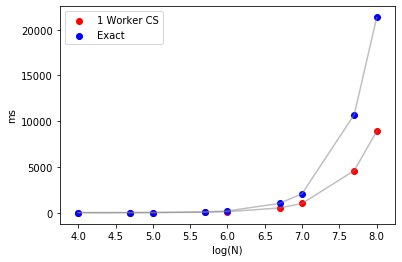

In [702]:
plot_scale(np.log10(sizeList[:9]),tSingle,teSingle,'log(N)')

In [691]:
stream_aug=stream_tr_aug.cpu().numpy()

In [ ]:
%time get_exact_HH(stream_aug[:sizeList[10]])  

In [ ]:
%time get_exact_HH(stream_aug[:sizeList[10]])  

In [ ]:
w

In [ ]:
%time get_exact_HH(stream_aug[:sizeList[10]])  

In [692]:
teSingle=[]
for size in sizeList:
    t=%timeit -o get_exact_HH(stream_aug[:size])    
    teSingle.append(t.average)
teSingle=np.array(teSingle)*1000

2.6 ms ± 354 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
10.1 ms ± 21.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
19.5 ms ± 1.17 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
93.5 ms ± 1.11 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
190 ms ± 880 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.02 s ± 6.66 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.08 s ± 10.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
10.7 s ± 584 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
21.3 s ± 642 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
t=%timeit -o get_exact_HH(stream_aug[:size])  

In [266]:
tSingle=[]
for size in sizeList:
    get_CS_HH(stream_tr[:size], 100000, 20000, 10, 1000, device=None)    
    tSingle.append(t.average)

6.23 ms ± 241 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
12.2 ms ± 370 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
14.9 ms ± 132 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
66.7 ms ± 3.93 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
117 ms ± 2.77 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
564 ms ± 20 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.07 s ± 60.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.16 s ± 79.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Text(0, 0.5, 'ms')

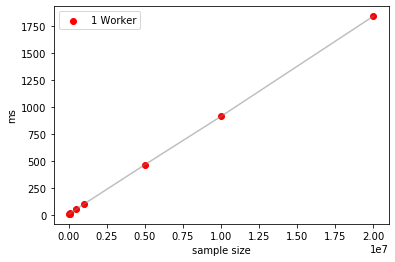

In [299]:
plt.scatter(sizeList,tSingle, c='red', label='1 Worker')
plt.plot(sizeList,tSingle, c='grey', alpha=0.5)
plt.legend()
plt.xlabel('sample size')
plt.ylabel('ms')

In [102]:
%prun HH,freq,t=get_CS_HH(stream,d,c,r,topk,device)

In [119]:
%timeit HH,freq,t=get_CS_HH(stream0,d,c,r,topk,device)
%timeit HH,freq,t=get_CS_HH(stream0,d,c,r,topk,device)

CPU times: user 31.6 ms, sys: 980 µs, total: 32.6 ms
Wall time: 15.6 ms


2

top 3150|err 92619.99|Acc5% 1.0 | Acc50% 0.76


In [353]:
errVec,err,setAcc = get_relative_error(exactHH,mHHs, mfreqs, True, k=3150)

top 3150|err 3085.84|Acc5% 1.0 | Acc50% 0.96


In [336]:
errVec,err,setAcc = get_relative_error(exactHH,cHH, cfreq, True, k=3150)

top 3150|err 747.73|Acc5% 1.0 | Acc50% 0.81


In [221]:
data

array([[ 6.90171483, 12.16961908, 10.90853565, 11.59461348,  5.61500318,
         3.5472393 , 11.97416957,  7.86587463],
       [ 7.17805242,  8.08836271,  3.93636591,  3.78795513,  3.77934333,
        10.87651992,  3.72601538, 12.55552046],
       [ 5.84371928,  4.44981989,  9.92746658,  9.15264454,  7.88559726,
        10.72655833,  3.23086134, 11.71831104],
       [ 6.88932874,  9.57638422,  6.11926143, 11.85036528,  3.53809645,
         6.87066997,  7.31633041,  9.01281039]])

In [220]:
data.shape

(4, 8)

In [334]:
d=100000
r=10
k=1000
c=20000

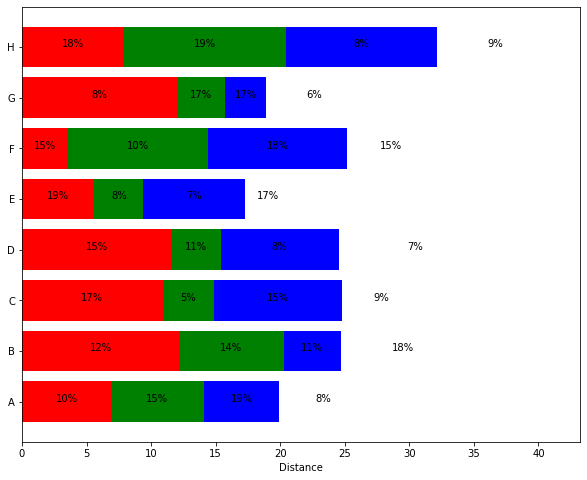

In [218]:
import numpy as np
import matplotlib.pyplot as plt

people = ('Exact','r',)
segments = 2

# generate some multi-dimensional data & arbitrary labels
data = 3 + 10* np.random.rand(segments, len(people))
percentages = (np.random.randint(5,20, (len(people), segments)))
y_pos = np.arange(len(people))

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

colors ='rgbwmc'
patch_handles = []
left = np.zeros(len(people)) # left alignment of data starts at zero
for i, d in enumerate(data):
    patch_handles.append(ax.barh(y_pos, d, 
      color=colors[i%len(colors)], align='center', 
      left=left))
    # accumulate the left-hand offsets
    left += d

# go through all of the bar segments and annotate
for j in range(len(patch_handles)):
    for i, patch in enumerate(patch_handles[j].get_children()):
        bl = patch.get_xy()
        x = 0.5*patch.get_width() + bl[0]
        y = 0.5*patch.get_height() + bl[1]
        ax.text(x,y, "%d%%" % (percentages[i,j]), ha='center')

ax.set_yticks(y_pos)
ax.set_yticklabels(people)
ax.set_xlabel('Distance')

plt.show()